# ANN-to-SNN conversion

Download the Jupyter notebook : [ANN2SNN.ipynb](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/docs/example/ANN2SNN.ipynb)

This notebook demonstrates how to transform a neural network trained using tensorflow/keras into an SNN network usable in ANNarchy.

The models are adapted from the original models used in:

> Diehl et al. (2015) "Fast-classifying, high-accuracy spiking deep networks through weight and threshold balancing" Proceedings of IJCNN. doi: 10.1109/IJCNN.2015.7280696

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

First we need to download and process the MNIST dataset provided by tensorflow.

In [2]:
# Download data
(X_train, t_train), (X_test, t_test) = tf.keras.datasets.mnist.load_data()

# Normalize inputs
X_train = X_train.reshape(X_train.shape[0], 784).astype('float32') / 255.
X_test = X_test.reshape(X_test.shape[0], 784).astype('float32') / 255.

# One-hot output vectors
T_train = tf.keras.utils.to_categorical(t_train, 10)
T_test = tf.keras.utils.to_categorical(t_test, 10)

## Training an ANN in tensorflow/keras

The `tensorflow` networks are build using the functional API. 

The fully-connected network has two fully connected layers with ReLU, **no bias**, dropout at 0.5, and a softmax output layer with 10 neurons. We use the standard SGD optimizer and the categorical crossentropy loss for classification.

In [3]:
def create_mlp():
    # Model
    inputs = tf.keras.layers.Input(shape=(784,))
    x= tf.keras.layers.Dense(128, use_bias=False, activation='relu')(inputs)
    x = tf.keras.layers.Dropout(0.5)(x)
    x= tf.keras.layers.Dense(128, use_bias=False, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x=tf.keras.layers.Dense(10, use_bias=False, activation='softmax')(x)

    model= tf.keras.Model(inputs, x)

    # Optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)

    # Loss function
    model.compile(
        loss='categorical_crossentropy', # loss function
        optimizer=optimizer, # learning rule
        metrics=['accuracy'] # show accuracy
    )
    print(model.summary())

    return model

We can now train the network and save the weights in the HDF5 format.

2024-03-21 18:22:21.136859: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-03-21 18:22:21.136881: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-21 18:22:21.136886: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-21 18:22:21.136918: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-21 18:22:21.136931: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 128)               100352    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16384     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1280      
                                                                 
Total params: 118016 (461.00 KB)
Trainable params: 118016 (46

2024-03-21 18:22:21.538737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-03-21 18:22:21.554781: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp.


422/422 [==============================] - 5s 12ms/step - loss: 1.0276 - accuracy: 0.6668 - val_loss: 0.3162 - val_accuracy: 0.9148
Epoch 2/20
422/422 [==============================] - 5s 12ms/step - loss: 0.4771 - accuracy: 0.8611 - val_loss: 0.2323 - val_accuracy: 0.9318
Epoch 3/20
422/422 [==============================] - 5s 11ms/step - loss: 0.3813 - accuracy: 0.8909 - val_loss: 0.1912 - val_accuracy: 0.9455
Epoch 4/20
422/422 [==============================] - 5s 11ms/step - loss: 0.3270 - accuracy: 0.9065 - val_loss: 0.1677 - val_accuracy: 0.9510
Epoch 5/20
422/422 [==============================] - 5s 12ms/step - loss: 0.2941 - accuracy: 0.9152 - val_loss: 0.1522 - val_accuracy: 0.9570
Epoch 6/20
422/422 [==============================] - 5s 11ms/step - loss: 0.2663 - accuracy: 0.9230 - val_loss: 0.1410 - val_accuracy: 0.9615
Epoch 7/20
422/422 [==============================] - 5s 11ms/step - loss: 0.2464 - accuracy: 0.9294 - val_loss: 0.1297 - val_accuracy: 0.9633
Epoch 8/20

/Users/vitay/.virtualenvs/ANNarchy/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Test accuracy: 0.9671000242233276


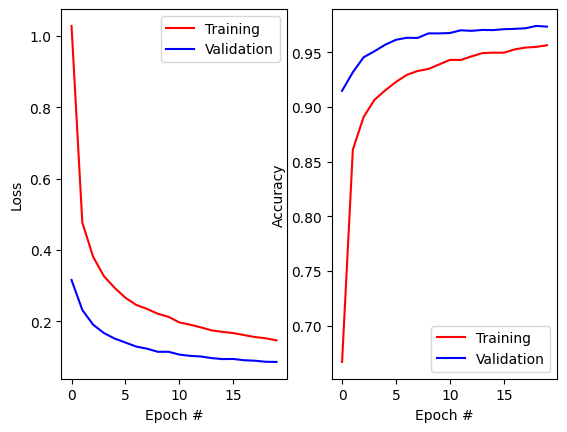

In [4]:
# Create model
model = create_mlp()

# Train model
history = model.fit(
    X_train, T_train,       # training data
    batch_size=128,          # batch size
    epochs=20,              # Maximum number of epochs
    validation_split=0.1,   # Percentage of training data used for validation
)
model.save("runs/mlp.h5")

# Test model
predictions_keras = model.predict(X_test, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, T_test, verbose=0)
print(f"Test accuracy: {test_accuracy}")

plt.figure()
plt.subplot(121)
plt.plot(history.history['loss'], '-r', label="Training")
plt.plot(history.history['val_loss'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], '-r', label="Training")
plt.plot(history.history['val_accuracy'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Initialize the ANN-to-SNN converter

We first create an instance of the ANN-to-SNN conversion object. The function receives the *input_encoding* parameter, which is the type of input encoding we want to use. 

By default, there are *intrinsically bursting* (`IB`), *phase shift oscillation* (`PSO`) and *Poisson* (`poisson`) available.

In [5]:
from ANNarchy.extensions.ann_to_snn_conversion import ANNtoSNNConverter

snn_converter = ANNtoSNNConverter(
    input_encoding='IB',
    hidden_neuron='IaF', 
    read_out='spike_count',
)

ANNarchy 4.7 (4.7.3) on darwin (posix).


After that, we provide the TensorFlow model stored as h5py file to the conversion tool. The print-out of the network structure of the imported network is suppressed when *show_info*=False is provided to *init_from_keras_model*.

In [6]:
net = snn_converter.init_from_keras_model("runs/mlp.h5", show_distributions=True)

Parameters
----------------------
* input encoding: IB
* hidden neuron: IaF neuron
* read-out method: spike_count

Layers
----------------------
* name=dense, dense layer, geometry=128
* name=dense_1, dense layer, geometry=128
* name=dense_2, dense layer, geometry=10

Projections
----------------------
* input_1 (784,) -> dense (128,)
    weight matrix size (128, 784)
    mean -0.0021713783498853445, std 0.052132513374090195
    min -0.3114379048347473, max 0.2092430740594864
* dense (128,) -> dense_1 (128,)
    weight matrix size (128, 128)
    mean 0.007305823266506195, std 0.10028184950351715
    min -0.33722999691963196, max 0.5378042459487915
* dense_1 (128,) -> dense_2 (10,)
    weight matrix size (10, 128)
    mean -0.005615146365016699, std 0.20395728945732117
    min -0.5734260678291321, max 0.5247938632965088



When the network has been built successfully, we can perform a test using all MNIST training samples. Using `duration_per_sample`, the number of steps simulated for each image can be specified.

In [7]:
predictions_snn = snn_converter.predict(X_test, duration_per_sample=100)

Depending on the selected read-out method, it can happen that multiple neurons/classes are selected as a winner for an example. For example, if `duration_per_sample` is too low, several output neurons might output the same number of spikes. 

In the following cell, we force the predictions to keep only one of the winning neurons by using `np.random.choice`.

In [8]:
predictions_snn = [ [np.random.choice(p)] for p in predictions_snn ]

Using the recorded predictions, we can now compute the accuracy using scikit-learn for all presented samples.

In [9]:
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(t_test, predictions_snn))
print("Test accuracy of the SNN:", accuracy_score(t_test, predictions_snn))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.97      0.94      0.95      1032
           3       0.93      0.97      0.95      1010
           4       0.95      0.96      0.96       982
           5       0.96      0.94      0.95       892
           6       0.96      0.97      0.96       958
           7       0.96      0.96      0.96      1028
           8       0.95      0.95      0.95       974
           9       0.95      0.93      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

Test accuracy of the SNN: 0.9583


For comparison, here is the performance of the original SNN:

In [10]:
print(classification_report(t_test, predictions_keras.argmax(axis=1)))
print("Test accuracy of the ANN:", accuracy_score(t_test, predictions_keras.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.98      0.95      0.96      1032
           3       0.94      0.97      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.96      0.97       892
           6       0.97      0.97      0.97       958
           7       0.97      0.96      0.96      1028
           8       0.96      0.96      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Test accuracy of the ANN: 0.9671


A comparison of the predictions made by the ANN and the SNN on each class may reveal different behavior:

In [11]:
print(classification_report(predictions_keras.argmax(axis=1), predictions_snn))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       989
           1       0.98      0.99      0.99      1139
           2       0.97      0.97      0.97      1006
           3       0.96      0.97      0.97      1045
           4       0.97      0.97      0.97       986
           5       0.97      0.96      0.97       877
           6       0.98      0.98      0.98       964
           7       0.98      0.98      0.98      1025
           8       0.97      0.97      0.97       978
           9       0.97      0.97      0.97       991

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

